# Продажи австралийского вина

## Анализ временных рядов
Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980г. по июль 1995г.
Необходимо построить прогноз на следующие три года.

## Импорт модулей

In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Функция обратного преобразования Бокса-Кокса
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

## Загрузка данных

In [4]:
wine = pd.read_csv('monthly-australian-wine-sales.csv',
                   ',',
                   index_col = ['month'],
                   parse_dates = ['month'],
                   dayfirst = True)

In [5]:
wine.sales = wine.sales*1000

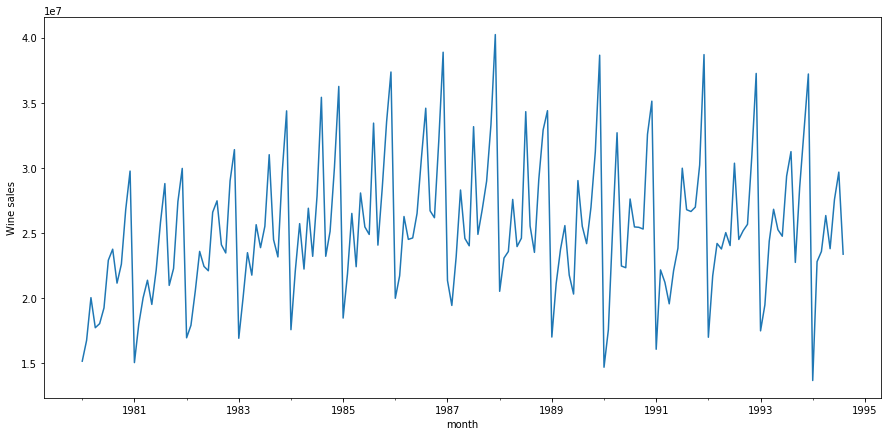

In [6]:
# Вывод ряда на экран
plt.figure(figsize(15,7))
wine.sales.plot()
plt.ylabel('Wine sales')
pylab.show()

У данного ряда достаточно сильно выраженная годовая сезонность, кроме того в нем присутствует нелинейный тренд, а также нестационарная дисперсия. Размах сезонных колебаний в начале ряда немного меньше, чем в конце ряда.

## Предварительный анализ ряда

### Проверка стационарности и STL-декомпозиция ряда

Критерий Дики-Фуллера: p = 0.0512


<Figure size 1080x720 with 0 Axes>

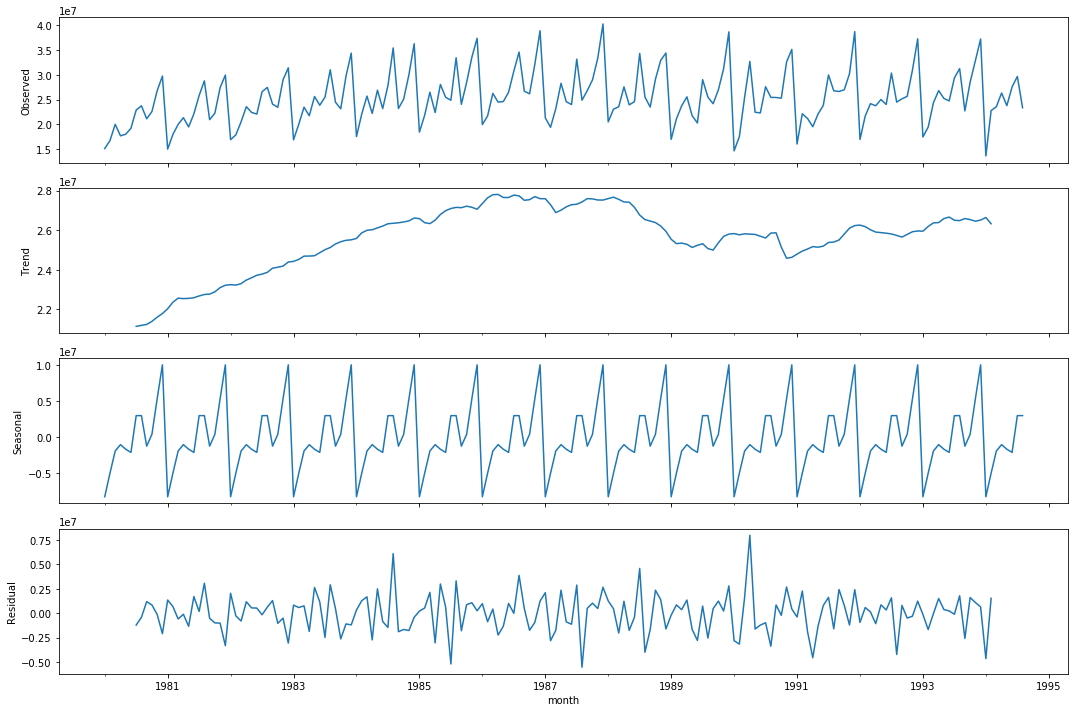

In [13]:
# Проверка ряда на стационарность с помощью критерия Дики-Фуллера
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wine.sales).plot()
print('Критерий Дики-Фуллера: p =', round(sm.tsa.stattools.adfuller(wine.sales)[1], 4))

Достигаемый уровень значимости критерия Дики-Фуллера немного больше 0,05, то есть гипотеза нестационарности для этого ряда не отвергается, однако значения — пограничны.

Проведем STL-декомпозицию — это некоторый набор эвристик, который позволяет визуально определить, из каких компонент состоит данный ряд. На графиках выше приведен результат применения STL-декомпозиции. На верхнем из четырёх графиков — исходный ряд. На нижних трёх соответственно тренд, сезонность и остатки. Сезонный профиль достаточно хорошо выражен. Тренд имеет достаточно сложную структуру. Сначала он повышается, затем доходит до некоторого пика, немного понижается и медленно возвращается на исходный уровень. Это ещё раз подтверждает, что ряд трудно считать стационарным.

### Стабилизация дисперсии методом Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса:  0.2367
Критерий Дики-Фуллера: p = 0.0296


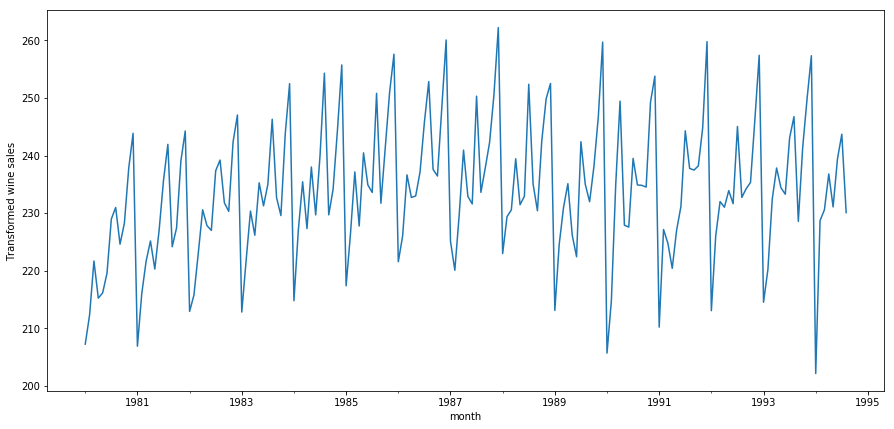

In [14]:
# Преобразование Бокса-Кокса для стабилизации дисперсии
wine['sales_box'], lmbda = stats.boxcox(wine.sales)
plt.figure(figsize(15,7))
wine.sales_box.plot()
plt.ylabel(u'Transformed wine sales')
print('Оптимальный параметр преобразования Бокса-Кокса: ', round(lmbda, 4))
print('Критерий Дики-Фуллера: p =', round(sm.tsa.stattools.adfuller(wine.sales_box)[1], 4))

На данном этапе выполним стабилизацию дисперсии методом Бокса-Кокса. Это делает функция boxcox, она возвращает преобразованный ряд и наилучшее подобранное значение параметра лямбда (λ). В данном случае это значение равно примерно 0,24. На графике представлен преобразованный ряд. Критерий Дики-Фуллера на этом ряде даёт достигаемый уровень значимости примерно 0,03. То есть нулевая гипотеза нестационарности отвергается, и этот ряд критерий Дики-Фуллера считает стационарным. Тем не менее, стационарным этот ряд считать нельзя, потому что в нём очень сильно выражена сезонность, а также в нём присутствует тренд, который изображен на графике на STL-декомпозиции. 

## Преобразование ряда к стационарному

Проведем сезонное дифференцирование, на продифференцированном ряде применим STL-декомпозицию и проверим ряд на стационарность.

Критерий Дики-Фуллера p = 0.1283


<Figure size 1080x720 with 0 Axes>

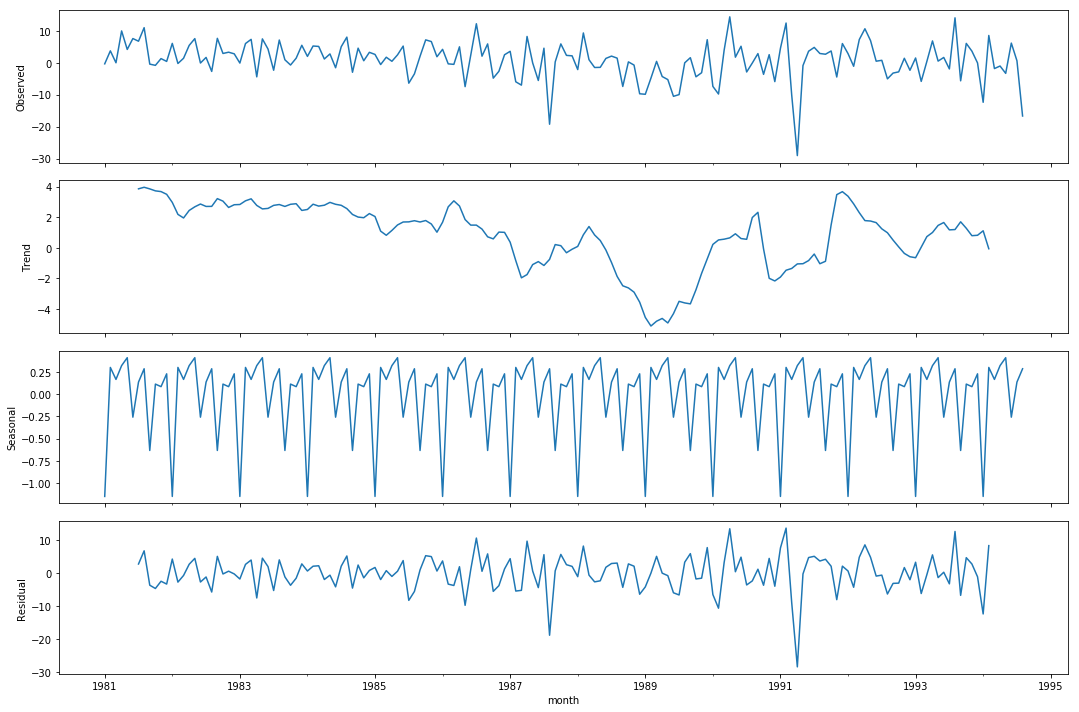

In [17]:
wine['sales_box_diff'] = wine.sales_box - wine.sales_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wine.sales_box_diff[12:]).plot()
print('Критерий Дики-Фуллера p =', round(sm.tsa.stattools.adfuller(wine.sales_box_diff[12:])[1], 4))

Критерий Дики-Фуллера не отвергает гипотезу нестационарности и полностью избавиться от тренда не удалось. Добавим обычное дифференцирование ряда.

Критерий Дики-Фуллера p = 2e-06


<Figure size 1080x720 with 0 Axes>

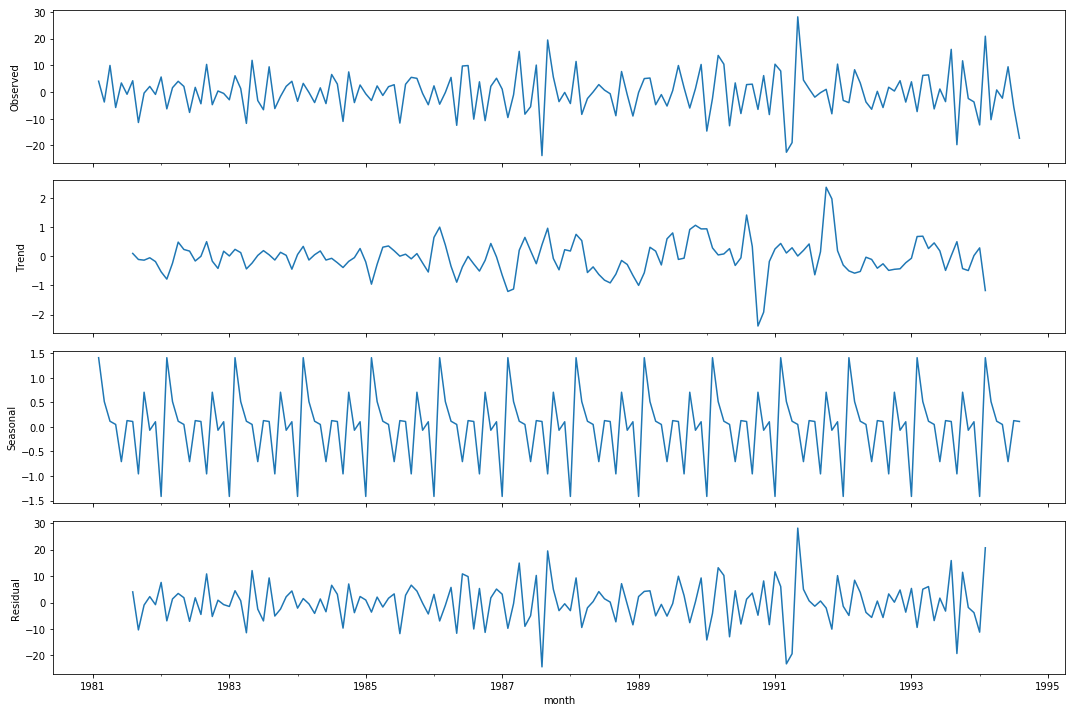

In [26]:
wine['sales_box_diff2'] = wine.sales_box_diff - wine.sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wine.sales_box_diff2[13:]).plot()
print('Критерий Дики-Фуллера p =', round(sm.tsa.stattools.adfuller(wine.sales_box_diff2[13:])[1], 6))

Гипотеза нестационарности отвергается (p = 2e-6 < 0.05), ряд можно считать стационарным.

## Подбор модели ARIMA

Визуально проверим ACF и PACF преобразованного ряда

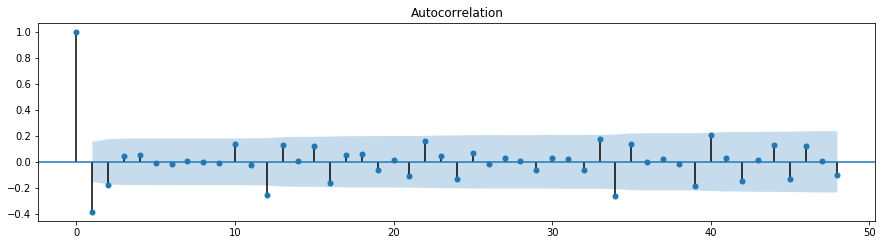

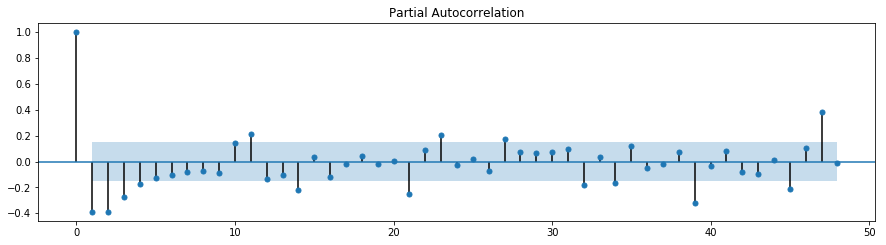

In [29]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wine.sales_box_diff2[13:].values.squeeze(), lags = 48, ax = ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wine.sales_box_diff2[13:].values.squeeze(), lags = 48, ax = ax)
pylab.show()

Посмотрим на автокорреляционную и частично автокорреляционную функцию преобразованного ряда. На верхнем графике — автокорреляционная функция, по этому графику подбирается начальное приближение для параметров q и Q. Максимальный сезонный лаг, значимо отличающийся от нуля, то есть выходящий за рамки синего коридора, это лаг 12. Таким образом, начальным приближением для Q будем брать единицу. Что касается q — здесь значимо отличаются от нуля первые два несезонных лага. Таким образом, для q начальное приближение будем брать равным двойке. Перейдём к начальному приближению для P. На частично автокорреляционной функции единственный сезонный лаг, значимо отличающийся от нуля — это лаг 12. Значит возьмём Р равным единице. Что касается p — в начале при маленьких лагах на частично автокорреляционной функции есть несколько значимо отличающихся от нуля. Возьмём p равным четырём.

Начальные приближения: Q=1, q=2, P=1, p=4.

Переберём все значения параметров p, P и q, Q от нуля до приближений, подобранных по графикам автокорреляционных функций.

In [30]:
ps = range(0,5)
d = 1
qs = range(0,3)
Ps = range(0,2)
D = 1
Qs = range(0,2)

In [31]:
parameters =product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print('Общее количество моделей равно', len(parameters_list))

Общее количество моделей равно 60


Настроим все модели и посчитаем для каждой значение информационного критерия Акаике, выберем ту модель, у которой это значение будет минимальным. Сезонная модель ARIMA настраивается с помощью функции SARIMAX из пакета statsmodels. Выводим на печать параметры каждой модели, которая не сошлась. 

In [32]:
%%time
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(wine.sales_box,
                                         order = (param[0], d, param[1]),
                                         seasonal_order = (param[2], D, param[3], 12)).fit(disp = -1)
    except:
        print('wrong parameters', param)
        continue
    aic = model.aic
    # сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters (0, 2, 0, 0)
wrong parameters (0, 2, 0, 1)
wrong parameters (0, 2, 1, 0)
wrong parameters (0, 2, 1, 1)
wrong parameters (3, 2, 0, 0)
wrong parameters (3, 2, 0, 1)
wrong parameters (3, 2, 1, 0)
wrong parameters (3, 2, 1, 1)
wrong parameters (4, 2, 0, 0)
wrong parameters (4, 2, 0, 1)
wrong parameters (4, 2, 1, 0)
wrong parameters (4, 2, 1, 1)
Wall time: 3min 19s


In [33]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending = True).head())

      parameters          aic
17  (1, 2, 0, 1)  1006.024479
25  (2, 1, 0, 1)  1007.801553
27  (2, 1, 1, 1)  1008.786538
29  (2, 2, 0, 1)  1009.284267
37  (3, 1, 0, 1)  1009.723537


Посмотрим на лучшие модели. Самый лучший результат, то есть результат с минимальным значением информационного критерия Акаике показала вот такая модель: p = 1, q = 2, P = 0 и Q = 1.

## Лучшая модель

In [34]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                  176
Model:             SARIMAX(1, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -498.012
Date:                            Mon, 17 Sep 2018   AIC                           1006.024
Time:                                    15:50:07   BIC                           1021.493
Sample:                                01-01-1980   HQIC                          1012.305
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9103      0.053     17.036      0.000       0.806       1.015
ma.L1         -1.9305      0.035   

## Визуальный анализ остатков модели

Критерий Стьюдента p = 0.38
Критерий Дики-Фуллера p = 0.0


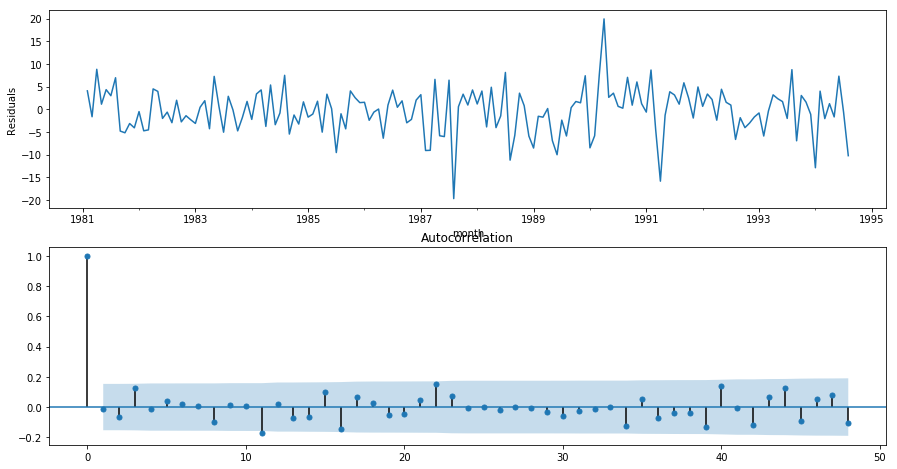

In [40]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags = 48, ax = ax)

print('Критерий Стьюдента p =', round(stats.ttest_1samp(best_model.resid[13:], 0)[1], 2))
print('Критерий Дики-Фуллера p =', round(sm.tsa.stattools.adfuller(best_model.resid[13:])[1], 4))

Критерий Стьюдента проверяет гипотезу несмещённости и её не отвергает с достигаемым уровнем значимости примерно 0,38. Критерий Дики-Фуллера уверенно отвергает гипотезу нестационарности. Критерий Льюнга-Бокса и коррелограмма подтверждают отсутствие автокорреляции. Таким образом,  получаем, что остатки не смещены, стационарны и неавтокоррелированы. Следовательно, модель достаточно хороша.

Проверим, насколько хорошо модель описывает данные.

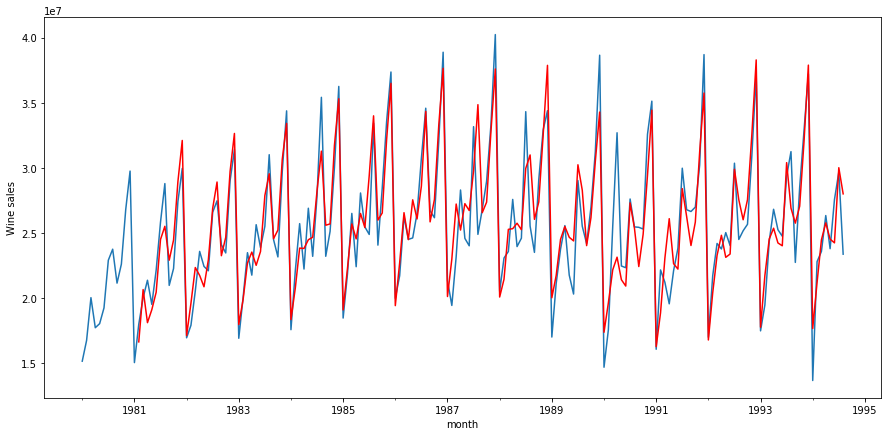

In [42]:
wine['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wine.sales.plot()
wine.model[13:].plot(color = 'r')
plt.ylabel('Wine sales')
pylab.show()

 Здесь синяя линия — это исходный ряд. А красная — это то, что предсказывает модель. Видно, что предсказания модели и исходные данные достаточно похожи друг на друга.

## Прогноз продаж вина

In [47]:
wine2 = wine[['sales']]
date_list = [datetime.datetime.strptime('1994-09-01', '%Y-%m-%d') + relativedelta(months = x) for x in range(0, 36)]
future = pd.DataFrame(index = date_list, columns = wine2.columns)
wine2 = pd.concat([wine2, future])
wine2['forecast'] = invboxcox(best_model.predict(start = 176, end = 211), lmbda)

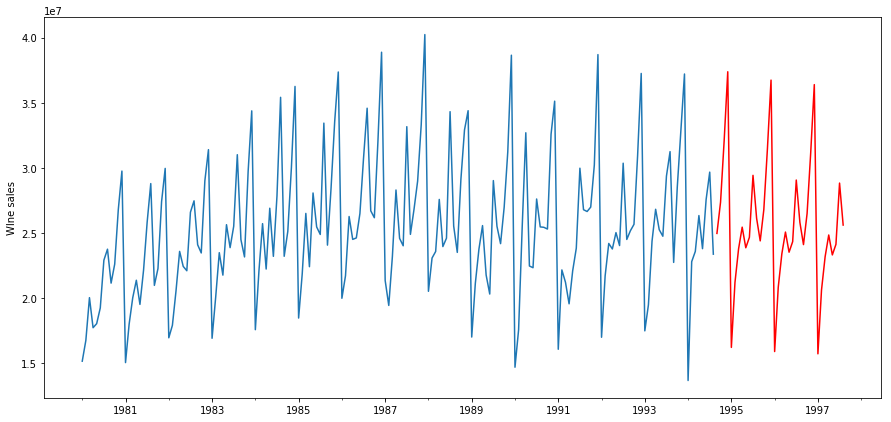

In [48]:
# Вывод графика прогноза продаж
plt.figure(figsize(15,7))
wine2.sales.plot()
wine2.forecast.plot(color = 'r')
plt.ylabel('WIne sales')
pylab.show()

На графике отображен результат прогнозирования. Здесь синее — это исходные данные для прогнозирования. Красное — это прогноз продаж вина на три года вперёд. Прогноз выглядит достаточно адекватным. Он передаёт то, известно о сезонности, глядя на предыдущую часть ряда, и в нём отсутствует тренд. Это происходит потому, что тренд имел достаточно сложную структуру, и в тот момент, в который производится предсказание, сложно знать заранее, будет ли средний уровень ряда дальше повышаться или понижаться.